In [1]:
%matplotlib inline
import torch
import torchvision
import hashlib
import pandas as pd
import zipfile
import time
from matplotlib import pyplot as plt
from IPython import display
from torch import nn
from torch.nn import functional as F
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

In [2]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

In [3]:
def forward(x, block):
    return block(x)

y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
y1.shape, y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [4]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

In [5]:
concat_preds([y1, y2]).shape

torch.Size([2, 25300])

In [6]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In [7]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

In [8]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i + 1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

In [9]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1, 1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

In [10]:
def blk_forward(x, blk, size, ratio, cls_predictor, bbox_predictor):
    y = blk(x)
    anchors = multibox_prior(y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(y)
    bbox_preds = bbox_predictor(y)
    return (y, anchors, cls_preds, bbox_preds)

In [11]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [12]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(
                self, f'cls_{i}',
                cls_predictor(idx_to_in_channels[i], num_anchors,
                              num_classes))
            setattr(self, f'bbox_{i}',
                    bbox_predictor(idx_to_in_channels[i], num_anchors))

    def forward(self, x):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            x, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                x, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(cls_preds.shape[0], -1,
                                      self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [13]:
def multibox_prior(data, sizes, ratios):
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height
    steps_w = 1.0 / in_width

    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:]))) \
        * in_height / in_width
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    anchor_manipulations = torch.stack(
        (-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2

    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                           dim=1).repeat_interleave(boxes_per_pixel, dim=0)

    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [14]:
net = TinySSD(num_classes=1)
x = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(x)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


In [15]:
def load_data_bananas(batch_size):
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return (train_iter, val_iter)

class BananasDataset(torch.utils.data.Dataset):
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (
            f' training examples' if is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

def read_data_bananas(is_train=True):
    data_dir = download_extract('banana-detection')
    csv_fname = os.path.join(data_dir,
                             'bananas_train' if is_train else 'bananas_val',
                             'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(
            torchvision.io.read_image(
                os.path.join(data_dir,
                             'bananas_train' if is_train else 'bananas_val',
                             'images', f'{img_name}')))
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

def download_extract(name, folder=None):
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download(name, cache_dir=os.path.join('../..', 'data')):
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB['banana-detection'] = (
    DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [16]:
batch_size = 32
train_iter, _ = load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [17]:
def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [18]:
device, net = try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

In [19]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

In [20]:
def cls_eval(cls_preds, cls_labels):
    return float(
        (cls_preds.argmax(dim=-1).type(cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

In [21]:
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: set_axes(self.axes[
                                                0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Timer:
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        self.tik = time.time()

    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        return sum(self.times) / len(self.times)

    def sum(self):
        return sum(self.times)

    def cumsum(self):
        return np.array(self.times).cumsum().tolist()

def use_svg_display():
    display.set_matplotlib_formats('svg')

class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def multibox_target(anchors, labels):
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = match_anchor_to_bbox(label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

def match_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    jaccard = box_iou(anchors, ground_truth)
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= 0.5).reshape(-1)
    box_j = indices[max_ious >= 0.5]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

def box_iou(boxes1, boxes2):
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)
    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]
    unioun = area1[:, None] + area2 - inter
    return inter / unioun

def offset_boxes(anchors, assigned_bb, eps=1e-6):
    c_anc = box_corner_to_center(anchors)
    c_assigned_bb = box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

def box_corner_to_center(boxes):
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class err 3.14e-03, bbox mae 3.08e-03
5347.6 examples/sec on cuda:0


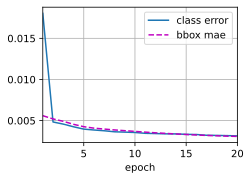

In [22]:
num_epochs, timer = 20, Timer()
animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    metric = Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        x, y = features.to(device), target.to(device)
        anchors, cls_preds, bbox_preds = net(x)
        bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, y)
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

In [23]:
x = torchvision.io.read_image('../../data/banana.jpg').unsqueeze(0).float()
img = x.squeeze(0).permute(1, 2, 0).long()

In [24]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.00999999978):
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat(
            (class_id.unsqueeze(1), conf.unsqueeze(1), predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

def offset_inverse(anchors, offset_preds):
    c_anc = box_corner_to_center(anchors)
    c_pred_bb_xy = (offset_preds[:, :2] * c_anc[:, 2:] / 10) + c_anc[:, :2]
    c_pred_bb_wh = torch.exp(offset_preds[:, 2:] / 5) * c_anc[:, 2:]
    c_pred_bb = torch.cat((c_pred_bb_xy, c_pred_bb_wh), axis=1)
    predicted_bb = box_center_to_corner(c_pred_bb)
    return predicted_bb

def box_center_to_corner(boxes):
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

def nms(boxes, scores, iou_threshold):
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

In [25]:
def predict(x):
    net.eval()
    anchors, cls_preds, bbox_preds = net(x.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(x)

In [26]:
def use_svg_display():
    from IPython import display
    display.set_matplotlib_formats('svg')


def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

def show_bboxes(axes, bboxes, labels=None, colors=None):

    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(numpy(bbox), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i], va='center',
                      ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

def bbox_to_rect(bbox, color):
    return plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2] - bbox[0],
                         height=bbox[3] - bbox[1], fill=False,
                         edgecolor=color, linewidth=2)

numpy = lambda x, *args, **kwargs: x.detach().numpy(*args, **kwargs)

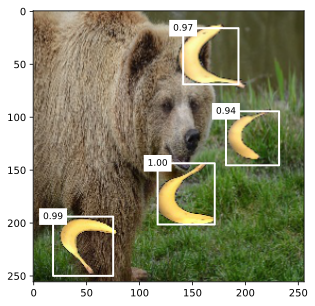

In [27]:
def display(img, output, threshold):
    set_figsize((5, 5))
    fig = plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.9)

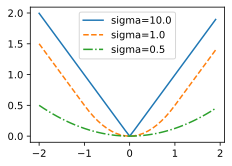

In [28]:
def smooth_l1(data, scalar):
    out = []
    for i in data:
        if abs(i) < 1 / (scalar**2):
            out.append(((scalar * i)**2) / 2)
        else:
            out.append(abs(i) - 0.5 / (scalar**2))
    return torch.tensor(out)

sigmas = [10, 1, 0.5]
lines = ['-', '--', '-.']
x = torch.arange(-2, 2, 0.1)
set_figsize()

for l, s in zip(lines, sigmas):
    y = smooth_l1(x, scalar=s)
    plt.plot(x, y, l, label='sigma=%.1f' % s)
plt.legend()

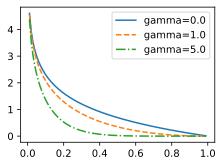

In [29]:
def focal_loss(gamma, x):
    return -(1 - x)**gamma * torch.log(x)

x = torch.arange(0.01, 1, 0.01)
for l, gamma in zip(lines, [0, 1, 5]):
    y = plt.plot(x, focal_loss(gamma, x), l, label='gamma=%.1f' % gamma)
plt.legend()